This is where I did the majority of my work for "Diagnostics from Polarization of Scattered Optical Light from Galactic Infrared Cirrus". A disclaimer: this file has extraneous code, and some code that may have been used to write text files has been removed; many text files in this repository are also redundant or were not used in the final results. This notebook is not to be taken as whole and complete, but rather can give you a very solid foundation for how the results were calculated in order to proceed with your own calculations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import math
import scipy as sp
from scipy.interpolate import interp1d
from astropy.io import fits
from tqdm import tqdm

In [2]:
def weighted_fxn(w1, w2, f1, f2):
    """Computes the weighted combined function given two of the same kind of function
    for two different compositions."""
    weighted = (w1*f1 + w2*f2)/(w1+w2)
    return(weighted)

In [3]:
def scat_dihedral_angle(l_1,b_1,l_2,b_2, ifn_ell):
    """Calculates the scattering and dihedral angle given an the coordinates pointing to the incoming radiation/
    and the coordinates to earth."""
    #defining meridian plane to be a vector in same plane but perpendicular 
    #to the scattered vector
    l_3 = l_2
    b_3 = b_2+90. #will guarantee there is a normal to meridional plane
    
    #adjusting l1, b1 coords to reflect the forward direction of incoming light
    #adjusting l2, b2 coords to change from earth's coord sys to dust particle's
    b1 = (b_1) * np.pi/180.
    l1 = (l_1+180.) * np.pi/180.
    b2 = (b_2) * np.pi/180.
    l2 = (l_2+180.) * np.pi/180.
    b3 = (b_3) * np.pi/180.
    l3 = (l_3+180.) * np.pi/180.

    #defining coordinates
    forward1 = np.cos(b1) * np.sin(l1)
    forward2 = np.cos(b1) * np.cos(l1)
    forward3 = np.sin(b1)
    scattered1 = np.cos(b2) * np.sin(l2)
    scattered2 = np.cos(b2) * np.cos(l2)
    scattered3 = np.sin(b2)
    meridian1 = np.cos(b3) * np.sin(l3)
    meridian2 = np.cos(b3) * np.cos(l3)
    meridian3 = np.sin(b3)
    
    #scat angle
    scat_angle = np.arccos((forward1 * scattered1) + 
                           (forward2 * scattered2) + 
                           (forward3 * scattered3))
    #forward or back scattering:
    if np.sin(scat_angle) < 1e-8:
        print("Forward or back scattering")
        scat_angle = 999
        dihedral_angle = 999
        return scat_angle, dihedral_angle
    
#     if l_1 == 135 or l_1 == 315 or l_1 == 495:
    if l_1 == ifn_ell:
        dihedral_angle = 180.
        return scat_angle*180./np.pi, dihedral_angle
    
    #arccos argument > 1, set to be arccos(1):
    if (forward1*meridian1 + forward2*meridian2 
        + forward3*meridian3) /np.sin(scat_angle) > 1:
        dihedral_angle = 0.
        return scat_angle*180./np.pi, dihedral_angle

    if (forward1*meridian1 + forward2*meridian2 + forward3*meridian3) \
        /np.sin(scat_angle) < -1:
        dihedral_angle = 180.
        return scat_angle*180./np.pi, dihedral_angle
    
    #dihedral angle
    dihedral_angle = np.arccos((forward1*meridian1 + forward2*meridian2 
                             + forward3*meridian3) /np.sin(scat_angle))
    return scat_angle *180./np.pi, dihedral_angle*180./np.pi

In [4]:
def Q(angle_array, weighted_Q, interp_type, l1, b1, l2, b2): 
    interpolation = interp1d(angle_array, weighted_Q, kind=interp_type) #linear by default
    return(interpolation(scat_dihedral_angle(l1, b1, l2, b2,l2)[0]))

In [5]:
rayleigh_I = np.loadtxt("rayleigh_phase.txt")
rayleigh_Q = np.loadtxt("rayleigh_pol.txt")

In [6]:
def rayleigh(angle_array, interp_type, l1, b1, l2, b2,):
    "interpolating the pol. phase fxn and phase fxn for the Rayleigh regime."
#these are now defined globally above ^
#     rayleigh_I = np.loadtxt("rayleigh_phase.txt")
#     rayleigh_Q = np.loadtxt("rayleigh_pol.txt")
    interpolation_I = interp1d(angle_array, rayleigh_I, kind=interp_type) #linear by default
    interpolation_Q = interp1d(angle_array, rayleigh_Q, kind=interp_type)
    return interpolation_I(scat_dihedral_angle(l1, b1, l2, b2)[0]), interpolation_Q(scat_dihedral_angle(l1, b1, l2, b2)[0])

In [7]:
def rot_matrix(angle_array, weighted_Q, interp_type, intensity, l1,b1,l2,b2, rayleigh = False):
    """Performs the general matrix multiplication that rotates the scattered [Q,U] \
    vector to be relative to 'true north'.
    """
    #Raleigh regime:
    if rayleigh ==True:
        Q_scat = rayleigh(angle_array, interp_type, l1,b1,l2,b2)[1] * intensity
    else:
        Q_scat = Q(angle_array, weighted_Q, interp_type, l1,b1,l2,b2) * intensity
    theta = scat_dihedral_angle(l1,b1,l2,b2,l2 )[1]
    U = 0.
    c, s = np.cos(2.*np.radians(theta)), np.sin(2.*np.radians(theta))
    R = np.array(((c, s), (s, c)))
    P = np.array((Q_scat, U))
    P_vector = np.transpose(P)
    product = np.matmul(R,P_vector)
    return product, Q_scat

In [8]:
def skyfilt(ifilt, z):
    """Reading in the array of intensity given an energy and height."""
    #heights = ['0.1', '0.2', '0.5', '1', '2', '5', '10', '20', '30']
    #insert file path below
    filepath = '/fs/lustre/project/hp/pgmartin/GALPROP/FITS/ISRF/Standard/Standard_8.5_0_'
    with fits.open(filepath + str(z) + '_Filter_HP.fits.gz') as hdul:
        print(hdul.info())
        skymap = hdul[1].data
        skymap_header = hdul[1].header
        energies = hdul[2].data
        skyfilt = skymap['spectra'][:,ifilt]
        return skyfilt , energies

In [1]:
#driver program:
def whole_sky(model, z, ifilt, nside, tmax, l2, b2, stmax, par_trans_rot = 1.294539149243122, kv_value = 1.23,
              anisotropic = True, info = True, mollview = False, smooth = False,\
              rayleigh = False, mezger = False, sandage = False, sandage_90 = False, sandage_0 = False,\
              galactic_centre = False, g = False, trig_check = False, sandage_rayleigh = False,
              start = 0, end = True, interp_type = 'linear'):
    """
    Prints the polarization and other parameters for a dust particle of a given /
    model, and a height z with a specified intensity.
    
    Default: runs frankie files, assumes anisotropic, no rayleigh scattering, no sandage disk model, not 
    just lit from the galactic centre.
    
    Parameters:
    model (int) : dust model is being used
    z (float) : height of dust particle out of galactic plane
    ifilt (array_like) : intensities corresponding to an energy
    aniso_check (Bool) : False overwrites the intensity from file for isotropic rad. field
    
    """
    total_pix = hp.nside2npix(nside)
    if end == True:
        end = total_pix

    #for vectors
    Q_sky = np.full(total_pix, 0, dtype = float)
    U_sky = np.full(total_pix, 0, dtype = float)
    I_sky = np.full(total_pix, 0, dtype = float)
    I_phase_fxn = np.full(total_pix, 0, dtype = float)
    scat_angle_array = np.full(total_pix, 0, dtype = float)
    scat_array = np.full(total_pix, 0, dtype = float)
#     Q_scat_array = np.full(total_pix, 0, dtype = float)
    
    if g == True:
        c_sky = np.full(total_pix, 0, dtype = float)
        g_array = np.full(total_pix, 0, dtype = float)

    if trig_check == True:
        cos = np.full(total_pix, 0, dtype = float)
        sin = np.full(total_pix, 0, dtype = float)
        theta = np.full(total_pix, 0, dtype = float)
    
    if sandage == True:
        cos_thetas = np.full(total_pix, 10e-24, dtype = float)
    
    #loading and identifying model
    angle_array = np.loadtxt("angle_array.txt")
    weighted_Q = np.loadtxt("weighted_Q_"+str(model)+".txt")
    weighted_phase_fxn = np.loadtxt("weighted_phase_fxn_"+str(model)+".txt")
    I_interpolation = interp1d(angle_array, weighted_phase_fxn, kind=interp_type)
    
    if info == True:
        if model == 0:
            print('Model 0, r band. \n Compeigne; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 1:
            print('Model 1, g band. \n Compeigne; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 2:
            print('Model 2, r band. \n Weingartner and Draine rv 3.1; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 3:
            print('Model 3, g band. \n Weingartner and Draine rv 3.1; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 4:
            print('Model 4, r band. \n Weingartner and Draine rv 5.5; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 5:
            print('Model 5, g band. \n Weingartner and Draine rv 5.5; Draine silicate, Zubko amorphous carbon. \n Height:', z, 'kpc. ')
        if model == 6:
            print('Model 6, r band. \n Astrodust w New size dist')
        if model == 7:
            print('Model 7, g band. \n Astrodust w New size dist')
        if model == 8:
            print('Model 8, r band. \n Astrodust w Weingartner Sil size dist')
        if model == 9:
            print('Model 9, g band. \n Astrodust w Weingartner Sil size dist')
        if model == 10:
            print('Model 10, r band. \n Astrodust w Compeigne Sil size dist')
        if model == 11:
            print('Model 11, g band. \n Astrodust w Compeigne Sil size dist')
     #isotropic or anisotropic
    if anisotropic == True:
        intensity_array = skyfilt(ifilt, z)
    else:
        intensity_array = np.ones(total_pix, dtype = float)
    
    #for Rayleigh:
    if rayleigh == True:
        I_interpolation = interp1d(angle_array, rayleigh_I, kind=interp_type)

        
    # SANDAGE 90
    if sandage_90 == True:
        intensity_array = np.full(total_pix, 0, dtype = float)
        b1 = 0
        l1 = 0
        for i in range(0,3600):
            l1 += 0.1
            equatorpix = hp.ang2pix(nside, l1, b1, lonlat = True)
        #                 intensity = intensity_array[equatorpix]
            intensity_array[equatorpix] = 1
      
    #############################################
    
    if mezger == True:
        print('setting up the uniform disk with extinction model')
        scaleh = 130  # pc 
        kv = kv_value   # how much tau per kpc in the uniform disk 
        tauvscaleh = kv * scaleh/1000.
        tauvscaleh = 0.19086211 #g
#         tauvscaleh = 0.13901505 #r
        # sensitivity to changing this is small:
        # tauvscaleh = 2. * tauvscaleh 
        # tauvscaleh = 0.5 * tauvscaleh 

        print('scaleh, kv, tauvscaleh ', scaleh, kv, tauvscaleh)

        print('nside uniform disk ', nside)
        total_pix = hp.nside2npix(nside) 
        rows = 1.0*total_pix 
        print('expected nside, rows ', nside, total_pix)
        illum = np.full(total_pix, 0, dtype = float) 

    # enable the whole lower heisphere 
        stmaxh = 90.0 # lower hemisphere only, at most 
        stmaxhr = stmaxh*np.pi/180.
        stmaxinf = 89.99 # avoid infinity from 1/cos(str) 
        stmaxinfr = stmaxinf*np.pi/180. 

    # confine to a cone like in Sandage 
#         stmax = 90.0
#         stmax = 70.0
        stmaxr = stmax*np.pi/180. 
    
    ###########################################
    
    for pixel in range(start,end):
        pix2ang = hp.pix2ang(nside, pixel, nest=False, lonlat=True)
        #taking parallel transport rotation into account:
        l1 = pix2ang[0] #- par_trans_rot
        b1 = pix2ang[1]
           
        
    #intensity (Sandage)    
        if sandage == True:
            if b1 < (tmax - 90):
                theta = 90 + b1
                cos_thetas[pixel] = 4 * np.pi * (1/ np.cos(np.pi/180. * theta))/total_pix
            intensity = cos_thetas[pixel]
         
        ####################
        elif mezger == True:
#             b1 = 90.0 - pix2ang[1] 
            if b1 <= (stmax - 90):
                strr = (np.pi/2) + (b1 *np.pi/180.) #converts measurement from equator to south
                # entire lower hemisphere 
                if (strr > stmaxinfr and strr <= stmaxhr):
                    illum[pixel] = 1.0 # avoids infinity in exp(-2.d0*tauvscaleh*infinity) 
                elif (strr <= stmaxinfr):
                    illum[pixel] = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(strr)) # mezger 1982, Equation C1 
            intensity = illum[pixel]
        
        
        ####################
        
        # SANDAGE 90 or 0
        elif sandage_90 == True:
            intensity = intensity_array[pixel]
        elif sandage_0 == True:
            if pixel == hp.ang2pix(nside, 0, -90, lonlat = True): 
                intensity = 1
            else:
                intensity = 0

                
    #intensity (gal centre):
        elif galactic_centre == True:
            if pixel == hp.ang2pix(nside, 0, 0, lonlat = True): 
                intensity = intensity_array[pixel]
            else:
                intensity = 0
        else:
            intensity = intensity_array[pixel]
        ifn_ell = l2
        scat_angle = scat_dihedral_angle(l1, b1, l2, b2, ifn_ell)[0]
        rotation = rot_matrix(angle_array, weighted_Q, interp_type, intensity, l1,b1,l2,b2)[0]
        
        #making vectors
        #Q_scat_array[pixel] = rot_matrix(angle_array, weighted_Q, interp_type, intensity, l1,b1,l2,b2)[1]
        #scat_array[pixel] = scat_dihedral_angle(l1, b1, l2, b2, ifn_ell)[0]
        #scat_angle_array[pixel] = scat_dihedral_angle(l1, b1, l2, b2, ifn_ell)[1]
        Q_sky[pixel] = rotation[0]
        U_sky[pixel] = rotation[1]
        
        I = I_interpolation(scat_angle)
        I_phase_fxn[pixel] = I
        I_sky[pixel] = (I * intensity)
        
        if g == True:
            c_sky[pixel] = (np.cos((np.pi/180.)*scat_angle) * I)
        
        if trig_check == True:
            cos[pixel] = (np.cos((np.pi/180.)*scat_angle))
            sin[pixel] = (np.sin((np.pi/180.)*scat_angle))
            theta[pixel] = scat_angle
        
    #totals
    Q_sky_t = sum(Q_sky)
    U_sky_t = sum(U_sky)
    I_sky_t = sum(I_sky)
    I_phase_t = sum(I_phase_fxn)
   
    #polarization and pol. angle
    pol_angle = (0.5*(math.atan2(U_sky_t,Q_sky_t))*180./np.pi)
    P_sky = ((Q_sky_t**2. + U_sky_t**2.)**0.5)

    ##########################
    
    if mezger == True:
        # numerical integral 
        tot_unifi = sum(illum)/rows *2.0 
        med_unifi = np.median(illum)*2.0 
        # analytical 
        ttau = 2.0*tauvscaleh 
        e1 = sp.special.exp1(ttau) 
        an_unifi = (1.0 -  ttau*(np.exp(-ttau)/ttau - e1)) # mezger 1982, Equation C2, C3 
        print('average tunifi, aunifi; median ',  tot_unifi, an_unifi, med_unifi) 

        stratav = np.arccos(-ttau/np.log(1.0 - an_unifi)) * 180./np.pi
        iatav = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(stratav*np.pi/180.)) 
        print('stratav , iatav ', stratav , iatav)
        thetaatav = 180.0 - stratav 
        batav = 90.0 - thetaatav 
        print('theta at av, b at av ', thetaatav, batav)

        iunifmin = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(0.)) 
        iunifmax = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(stmaxr)) 

        print('stmax, stmaxr ', stmax, stmaxr)
    
    ##############################
    
    if info == True:
        print('Q_sky:', "{:.7E}".format(Q_sky_t), 
              '\n U_sky:', "{:.7E}".format(U_sky_t), 
              '\n I_sky:', "{:.7E}".format(I_sky_t), 
              '\n P_sky:', "{:.7E}".format(P_sky), 
              '\n P_sky/I_sky (pol frac):',"{:.7E}".format(P_sky/I_sky_t), 
              '\n Integral of phase fxn I:', "{:.7E}".format(I_phase_t/end), 
              '\n Pol. angle:', pol_angle,
              '\n new r value:', I_sky_t/sum(intensity_array),
              '\n illumination sum:', sum(intensity_array))
        #for frankie, I_sky_t/sum(intensity_array)
        #for mezger, I_sky_t/sum(illum)

    if sandage or rayleigh== True:
        return pol_angle, P_sky, P_sky/I_sky_t, Q_sky_t, U_sky_t, I_sky_t

        # SANDAGE
    if sandage_90 == True or sandage_0 == True:
        return pol_angle, P_sky, P_sky/I_sky_t, Q_sky_t, U_sky_t, I_sky_t
    
    if g == True:
        g = sum(c_sky)/(I_phase_t)
#         cos = 4 * np.pi * sum(cos_thetas)/total_pix
        print('g:', g)
        
#     if mollview == True:
#         return Q_sky, U_sky, I_sky, pol_angle, P_sky/I_sky_t, illum
    #return pol_angle, P_sky, P_sky/I_sky_t, Q_sky_t, U_sky_t, I_sky_t
    return pol_angle, P_sky/I_sky_t, I_sky, Q_sky, U_sky 

In [ ]:
whole_sky(1, 0.2, 1, 32, 0, 195., 40.0,0)

In [51]:
f = open('test_scattangles2.txt', "w")
for value in tester[4]:
    f.write(str(value)) 
    f.write("\n")
f.close()

In [11]:
def lat_mover(model, z, ifilt, nside):
    ### varies the latitude from 0 to 90 for Spider's longitude.
    pol_angles = np.full(91, 0, dtype = float)
    pol_fracs = np.full(91, 0, dtype = float)
    angle_array = np.full(91, 0, dtype = float)
    illum_arrayy = np.full(91, 0, dtype = float)
    i_arrayy = np.full(91, 0, dtype = float)
    for lat in tqdm(range(0,91)):
        # adjust for mezger or non-mezger:
        wholesky = whole_sky(model, z, ifilt, nside, 0, 135., lat, 90, mezger = True, sandage = False, info = False, interp_type = 'linear', \
                  rayleigh = False, start = 0)
        pol_angles[lat] = wholesky[0]
        pol_fracs[lat] = 100 * wholesky[2]
        angle_array[lat] = lat
        illum_arrayy[lat] = wholesky[6]
        i_arrayy[lat] = wholesky[5]
        print(pol_angles, pol_fracs, angle_array)
    return pol_angles, pol_fracs, angle_array, i_arrayy, illum_arrayy

In [ ]:
ilatg = lat_mover(1,0.2,1,256)

In [129]:
lats90 = np.array([0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.,
 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89.,
 90.])

In [46]:
bs = []
zlist = [0,0.1,0.2,0.5,1,2,5,10,20,30]
for z in zlist:
    bvalue = np.arctan(np.tan(40*np.pi/180)*z/0.2)*180/np.pi
    bs.append(bvalue)
print(bs)

[0.0, 22.76047627461663, 40.0, 64.5127952135792, 76.59365039163256, 83.20380883625891, 87.27076804668998, 88.63460950363034, 89.31720781314989, 89.54479323740446]


In [ ]:
whole_sky(1,0,1,32,0,135,0,90)
whole_sky(1,0.1,1,32,0,135,22.7604,90)
whole_sky(1,0.2,1,32,0,135,40,90)
whole_sky(1,0.5,1,32,0,135,64.5,90)
whole_sky(1,1,1,32,0,135,76.59,90)
whole_sky(1,2,1,32,0,135,83.20,90)

In [3]:
def mezger_whole_sky(model, z, ifilt, nside, stmax):
    total_pix = hp.nside2npix(nside)
    pol_angle_tmax = np.full(stmax, 0, dtype = float)
    P_sky_tmax = np.full(stmax, 0, dtype = float)
    pol_frac_tmax = np.full(stmax, 0, dtype = float)
    Q_sky_tmax = np.full(stmax, 0, dtype = float)
    U_sky_tmax = np.full(stmax, 0, dtype = float)
    I_sky_tmax = np.full(stmax, 0, dtype = float)
    illum_array = np.full(stmax, 0, dtype = float)

    for theta in range(1,stmax+1):
        #whole sky takes theta, as theta is the changing value of tmax
        wholesky = whole_sky(model, z, ifilt, nside, 0, 135., 40., theta, mezger = True, sandage = False, 
                            info = False, interp_type = 'linear', rayleigh = False)
        #since pol angle is defined in the half plane, we can add 180 to the neg values to get smooth curve
        if wholesky[0] < 0:
            pol_angle_tmax[theta-1] = wholesky[0] + 180.
        else:
            pol_angle_tmax[theta-1] = wholesky[0]
        P_sky_tmax[theta-1] = wholesky[1]
        pol_frac_tmax[theta-1] = wholesky[2]
        Q_sky_tmax[theta-1] = wholesky[3]
        U_sky_tmax[theta-1] = wholesky[4]
        I_sky_tmax[theta-1] = wholesky[5]
        illum_array[theta-1] = wholesky[6]
        
    angle_array = np.loadtxt("angle_array.txt")
    thetas = angle_array[1:stmax+1]
    return pol_angle_tmax, pol_frac_tmax, Q_sky_tmax, \
        U_sky_tmax, P_sky_tmax, I_sky_tmax, thetas, illum_array, \
        sum(pol_angle_tmax), sum(pol_frac_tmax), sum(Q_sky_tmax), \
        sum(U_sky_tmax), sum(P_sky_tmax), sum(I_sky_tmax),

In [ ]:
mezgerskyg256 = mezger_whole_sky(1, 0.2, 1, 256, 90)

In [14]:
f = open('23mezgerg256illum.txt', "w")
for value in mezgerskyg256[6]:
    f.write(str(value)) 
    f.write("\n")
f.close()

In [ ]:
hp.mollview(whole_sky(0, 0.2, 3, 32, 0, 135., 40., 90, mollview=True)[5], norm = 'linear')
hp.graticule()

In [12]:
def sandage_whole_sky(model, z, ifilt, nside, t_max, l2 = 135., b2 = 40., par_trans_rot = 1.294539149243122,
              anisotropic = True, info = True, mollview = False, log = False, plot = True, points_only = False,\
              interp_type = 'linear', limit_89 = False):
    #take out tqdm in whole_sky when you use this for a cleaner output
    total_pix = hp.nside2npix(nside)
    pol_angle_tmax = np.full(t_max, 0, dtype = float)
    P_sky_tmax = np.full(t_max, 0, dtype = float)
    pol_frac_tmax = np.full(t_max, 0, dtype = float)
    Q_sky_tmax = np.full(t_max, 0, dtype = float)
    U_sky_tmax = np.full(t_max, 0, dtype = float)
    I_sky_tmax = np.full(t_max, 0, dtype = float)
    
    if points_only == False:
        for theta in tqdm(range(1,t_max+1)):
            #whole sky takes theta, as theta is the changing value of tmax
            wholesky = whole_sky(model, z, ifilt, nside, theta, 135., 40., 0, sandage = True, 
                                 info = False, anisotropic = True, \
                  rayleigh = False, mezger = False)
            #since pol angle is defined in the half plane, we can add 180 to the neg values to get smooth curve
            if wholesky[0] < 0:
                pol_angle_tmax[theta-1] = wholesky[0] + 180.
            else:
                pol_angle_tmax[theta-1] = wholesky[0]
            P_sky_tmax[theta-1] = wholesky[1]
            pol_frac_tmax[theta-1] = wholesky[2]
            Q_sky_tmax[theta-1] = wholesky[3]
            U_sky_tmax[theta-1] = wholesky[4]
            I_sky_tmax[theta-1] = wholesky[5]
    
#     ## SANDAGE thetamax = 90
#     print('sandage 90')
#     wholesky90 = whole_sky(model, z, ifilt, nside, 90, 135., 40., 0, sandage_90 = True, info = False)
#     if wholesky90[0] < 0:
#         pol_angle_90 = wholesky90[0] + 180.
#     else:
#         pol_angle_90 = wholesky90[0]
#     P_sky_90 = wholesky90[1]
#     pol_frac_90 = wholesky90[2]
#     Q_sky_90 = wholesky90[3]
#     U_sky_90 = wholesky90[4]
#     I_sky_90 = wholesky90[5]

#     ## SANDAGE thetamax = 0
#     print('sandage 0')
#     wholesky0 = whole_sky(model, z, ifilt, nside, 0, 135., 40., 0, sandage_0 = True, info = False)
#     if wholesky0[0] < 0:
#         pol_angle_0 = wholesky0[0] + 180.
#     else:
#         pol_angle_0 = wholesky0[0]
#     P_sky_0 = wholesky0[1]
#     pol_frac_0 = wholesky0[2]
#     Q_sky_0 = wholesky0[3]
#     U_sky_0 = wholesky0[4]
#     I_sky_0 = wholesky0[5]
#     print('pol_angle_90', pol_angle_90)
#     print('pol_angle_0', pol_angle_0) 
#     print('pol_frac_90', pol_frac_90)
#     print('pol_frac_0', pol_frac_0)
                         
#     angle_array = np.loadtxt("angle_array.txt")
#     thetas = angle_array[1:t_max+1]
    
#     if log == True:
#         plt.plot(thetas, pol_angle_tmax, 'red')
#         plt.plot(90, pol_angle_90, 'x')
#         plt.plot(0, pol_angle_0, 'x')
#         plt.show()
#         plt.plot(thetas, pol_frac_tmax, 'orange')
#         plt.plot(90, pol_frac_90, 'x')
#         plt.plot(0, pol_frac_0, 'x')
#         plt.show()
#         plt.plot(thetas, Q_sky_tmax, 'yellow')
#         plt.yscale('symlog')
#         plt.plot(thetas, U_sky_tmax, 'green')
#         plt.yscale('symlog')
#         plt.plot(thetas, I_sky_tmax, 'blue')
#         plt.yscale('symlog')
#         plt.plot(thetas, P_sky_tmax, 'm')
#         plt.yscale('symlog')
#     elif plot == True:
#         if points_only == True:
#             plt.plot(90, pol_angle_90, 'x')
#             plt.plot(0, pol_angle_0, 'yx')
#             plt.ylabel('pol angle')
#             plt.show()
#             plt.plot(90, pol_frac_90, 'x')
#             plt.plot(0, pol_frac_0, 'rx')
#             plt.ylabel('pol frac')
#             plt.show()

#         if points_only == False:  
#             plt.plot(thetas, pol_angle_tmax, 'red')
#             plt.plot(90, pol_angle_90, 'x')
#             plt.plot(0, pol_angle_0, 'yx')
#             plt.show()
#             plt.plot(thetas, pol_frac_tmax, 'orange')
#             plt.plot(90, pol_frac_90, 'x')
#             plt.plot(0, pol_frac_0, 'rx')
#             plt.show()
#             plt.plot(thetas, 30 * Q_sky_tmax, 'yellow')
#             plt.plot(thetas, 20 * U_sky_tmax, 'green')
#             plt.plot(thetas, I_sky_tmax, 'blue')
#             plt.plot(thetas, 16 * P_sky_tmax, 'm')
        
#     print('pol angle', 'pol_frac', 'Q_sky', 'U_sky', 'P_sky', 'I_sky')
#     if limit_89 == True:
#         return pol_angle_tmax, pol_frac_tmax, pol_angle_0, pol_frac_0, pol_angle_90, pol_frac_90,
        
    return pol_angle_tmax, pol_frac_tmax, Q_sky_tmax, \
            U_sky_tmax, P_sky_tmax, I_sky_tmax, thetas,\
            sum(pol_angle_tmax), sum(pol_frac_tmax), sum(Q_sky_tmax), \
            sum(U_sky_tmax), sum(P_sky_tmax), sum(I_sky_tmax),
#     return angle_array[0:tmax+1], pol_angle_tmax, P_sky_tmax, pol_frac_tmax

In [4]:
def cloud_mover(model, z, ifilt):
    """ Varies the longitude of cirrus from 0 to 360. Currently set to Spider's location. """  
    gpol_angles = np.full(361, 0, dtype = float)
    gpol_fracs = np.full(361, 0, dtype = float)
    gQ_sky = np.full(361, 0, dtype = float)
    gU_sky = np.full(361, 0, dtype = float)
    gI_sky = np.full(361, 0, dtype = float)
    gP_sky = np.full(361, 0, dtype = float)
    for long in tqdm(range(0,361)):
        gwholesky = whole_sky(model, 0.2, ifilt, 32, 0, long, 40., 0,sandage = False, info = True, interp_type = 'linear', anisotropic = True, \
                  rayleigh = False, start = 0)
        print(long)
        gpol_angles[long] = gwholesky[0]
        gpol_fracs[long] = 100 * gwholesky[1]
#         gQ_sky[long] = gwholesky[2]
#         gU_sky[long] = gwholesky[3]
#         gI_sky[long] = gwholesky[4]
#         gP_sky[long] = gwholesky[5]
    return gpol_angles, gpol_fracs#, gQ_sky, gU_sky, gI_sky, gP_sky

In [ ]:
rad = cloud_mover(6,0.2,3)

In [5]:
#  the uniform disk with extinction model, also now included and updated in driver program
def mezger(nside):
    print('setting up the uniform disk with extinction model')
    scaleh = 130                 # pc 
    kv = 1.23          # how much tau per kpc in the uniform disk 
    kv = 1.  #how much tau per kpc in the uniform disk 
    tauvscaleh = kv * scaleh/1000. 
    # ; sensitivity to changing this is small 
    # ;tauvscaleh = 2. * tauvscaleh 
    # ;tauvscaleh = 0.5 * tauvscaleh 

    print('scaleh, kv, tauvscaleh ', scaleh, kv, tauvscaleh)

    print('nside uniform disk ', nside)
    total_pix = hp.nside2npix(nside) 
    rows = 1.0*total_pix 
    print('expected nside, rows ', nside, total_pix)
    illum = np.full(total_pix, 0, dtype = float) 
    
#     ; enable the whole lower heisphere 
    stmaxh = 90.0 # lower hemisphere only, at most 
    stmaxhr = stmaxh*np.pi/180.
    stmaxinf = 89.99 # avoid infinity from 1/cos(str) 
    stmaxinfr = stmaxinf*np.pi/180. 
    
#     ; confine to a cone  like in Sandage 
    stmax = 90.0 #confine to a cone  like in Sandage 
#     stmax =70.0 # confine to a cone 
    stmaxr = stmax*np.pi/180. 
    
    for pixel in range (0,total_pix): # actual loop 
        pix2ang = hp.pix2ang(nside, pixel, nest=False, lonlat=True)
        l1 = pix2ang[0]

        b1 = pix2ang[1] ## SHANNON'S
        if b1 < (stmax - 90):
            strr = np.pi + b1 *np.pi/180. #converts measurement from equator to south
    #  entire lower hemisphere 
            if (strr > stmaxinfr and strr <= stmaxhr):
                illum[pixel] = 1.0 # avoids infinity in exp(-2.d0*tauvscaleh*infinity) 
            elif (strr <= stmaxinfr):
                illum[pixel] = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(strr)) # mezger 1982, Equation C1 
        intensity = illum[pixel]

# numerical integral 
    tot_unifi = sum(illum)/rows *2.0 
    med_unifi = np.median(illum)*2.0 
# analytical 
    ttau = 2.0*tauvscaleh 
    e1 = sp.special.exp1(ttau) 
    an_unifi = (1.0 -  ttau*(np.exp(-ttau)/ttau - e1)) # mezger 1982, Equation C2, C3 
    print('average tunifi, aunifi; median ',  tot_unifi, an_unifi, med_unifi) 

    stratav = np.arccos(-ttau/np.log(1.0 - an_unifi)) * 180./np.pi
    iatav = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(stratav*np.pi/180.)) 
    print, 'stratav , iatav ', stratav , iatav 
    thetaatav = 180.0 - stratav 
    batav = 90.0 - thetaatav 
    print('theta at av, b at av ', thetaatav, batav)
      
    iunifmin = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(0.)) 
    iunifmax = 1.0 - np.exp(-2.0*tauvscaleh/np.cos(stmaxr)) 
     
    print('stmax, stmaxr ', stmax, stmaxr)

In [44]:
sandageang256 = [89.44759006, 89.44759006, 88.93972544, 88.3356405,  87.83564272, 87.24050229, 86.74959426,
 86.16770494, 85.68955785, 85.12476454, 84.6622288,  84.11763762, 83.67295036,
 83.23684848, 82.72515795, 82.30857091, 81.8204333,  81.42335333, 80.95822654,
 80.57977732, 80.20925255, 79.77446299, 79.41973009, 79.00227762, 78.66051206,
 78.32356235, 77.92454062, 77.59556113, 77.26896383, 76.87906643, 76.55489687,
 76.23054877, 75.90522365, 75.5124524, 75.18226327, 74.84866486, 74.51095223,
 74.16844384, 73.75019082, 73.39488667, 73.0328136,  72.66343295, 72.28623284,
 71.90073853, 71.50649827, 71.10309831, 70.606389,  70.18152877, 69.7463878,
 69.30413184, 68.85976464, 68.41316035, 67.9642461,  67.51297112, 66.96827578,
 66.51169253, 65.96057794, 65.49862257, 64.9410316,  64.37989423, 63.81518635,
 63.34184275, 62.77047599, 62.19537832, 61.61644332, 61.03351962, 60.44643169,
 59.85494541, 59.15891954, 58.5568077, 57.9491242,  57.33534973, 56.61069227,
 55.98128991, 55.23605812, 54.58662043, 53.81459192, 53.13865841, 52.33066489,
 51.61862208, 50.76074116, 49.99761248, 49.06761088, 48.08431456, 47.18751146,
 46.05851353, 44.80691928, 43.59130822, 41.89990731, 39.59565755]

In [45]:
sandagefrac256 = [0.0521058, 0.0521058,  0.05217852, 0.0523264,  0.05250161, 0.05277254, 0.05304967,
 0.05344378, 0.0538241,  0.05434425, 0.05483137, 0.05548101, 0.05607718,
 0.05672375, 0.05756679, 0.05832599, 0.05930559, 0.06017946, 0.06129745,
 0.06228714, 0.06332954, 0.06464965, 0.06580696, 0.06726343, 0.06853268,
 0.06985117, 0.07149647, 0.07291823, 0.07438401, 0.07619802, 0.07775273,
 0.07934361, 0.08096764, 0.08295564, 0.08464075, 0.08634768,0.08807239,
 0.08981072, 0.09190848, 0.09366106, 0.09541266, 0.09715847, 0.09889362,
 0.10061313, 0.10231197, 0.10398505, 0.10595162, 0.10755019, 0.10910679,
 0.11060498, 0.11202543, 0.11336783, 0.11463194, 0.11581771, 0.11713725,
 0.11815076, 0.11926395, 0.12010597, 0.12101391, 0.1218105, 0.12249617,
 0.12298315, 0.12346663, 0.12384045, 0.12410501, 0.12426065, 0.12430772,
 0.12424649, 0.12403845, 0.12374316, 0.12333992, 0.12282867, 0.12209531,
 0.12134883, 0.12033965, 0.11935504, 0.11806516, 0.11683667, 0.11525705,
 0.1137743,  0.1118887,  0.11013308, 0.10791235, 0.10549082, 0.10323838,
 0.10037433, 0.09720414, 0.09417248, 0.0901016,  0.08496095]
for i in range(0,len(sandagefrac256)):
    sandagefrac256[i] = sandagefrac256[i]*100

In [46]:
for i in range(0,len(mezgerfrac256)):
    mezgerfrac256[i] = mezgerfrac256[i]*100
for i in range(0,len(mezgergfrac256)):
    mezgergfrac256[i] = mezgergfrac256[i]*100
for i in range(0,len(sandageg256frac)):
    sandageg256frac[i] = sandageg256frac[i]*100

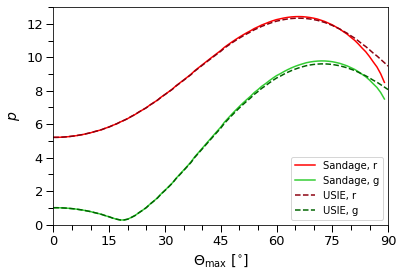

In [47]:
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=MEDIUM_SIZE)  
plt.rc('axes', labelsize=label_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE)  
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.margins(x=0,y=0)
plt.plot(mezgertheta256[0:90], sandagefrac256, 'r', label = "Sandage, r")
plt.plot(mezgertheta256[0:90], sandageg256frac, 'limegreen', label = "Sandage, g")
plt.plot(mezgertheta256, mezgerfrac256, '#8C000F', linestyle = "dashed", label = "USIE, r")
plt.plot(mezgertheta256, mezgergfrac256, 'darkgreen', linestyle = "dashed", label = "USIE, g")
plt.ylabel("$\it{p}$")
plt.xlabel("$\u0398_{\mathregular{max}}~[^{\circ}]$")
ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticks([5,10,20,25,35,40,50,55,65,70,80,85], minor = True)
ax.set_yticks([0,1,3,5,7,9, 11, 13], minor = True)
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc = 'lower right')
plt.savefig("./plots/USIEsandfrac_revised.pdf", dpi = 600, bbox_inches="tight")
plt.show()

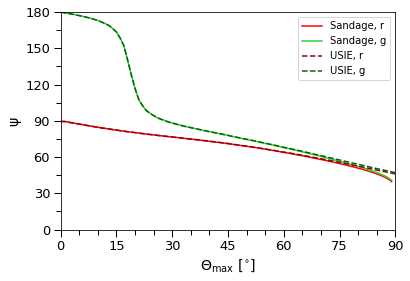

In [48]:
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=label_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.margins(x=0,y=0)
#8C000F, #BBE90F'
plt.plot(mezgertheta256[0:90], sandageang256, 'r', label = "Sandage, r")
plt.plot(mezgertheta256[0:90], sandageg256ang, 'limegreen', label = "Sandage, g")
plt.plot(mezgertheta256, mezgerang256, '#8C000F', linestyle = "dashed", label = "USIE, r")
plt.plot(mezgertheta256, mezgergang256, 'darkgreen', linestyle = "dashed", label = "USIE, g")
# plt.yscale("log")
plt.ylabel("\u03C8")
plt.xlabel("$\u0398_{\mathregular{max}}~[^{\circ}]$")
ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticks([0,5,10,20,25,35,40,50,55,65,70,80,85], minor = True)
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
# ax.set_yticks([0,15,30,45,60,75,90])
# ax.set_yticks([15,75], minor = True)
ax.set_yticks([0,30,60,90,120,150,180])
ax.set_yticks([15,45,75,105,135,165], minor = True)
plt.legend(loc = "upper right")
plt.savefig("./plots/USIEsandang_revised.pdf", dpi = 600, bbox_inches="tight")
plt.show()


In [49]:
# mezgerg256i = np.loadtxt('23mezgerg256irealone.txt')
# mezgerg256illum = np.loadtxt('23mezgerg256illum.txt')
# mezgerr256i = np.loadtxt('23mezgerr256i.txt')
# mezgerr256illum = np.loadtxt('23mezgerr256illum.txt')

# sandageg256i = np.loadtxt('23sandageg256i.txt')
# sandage256illum = np.loadtxt('23sand256illum.txt')
# sandager256i = np.loadtxt('23sandager256i.txt')

In [50]:
# I_normmezgerg = np.full(91, 0, dtype = float)
# for ele in range(0,91):
#     I_normmezgerg[ele] = mezgerg256i[ele]/mezgerg256illum[ele]
# print(I_normmezgerg) 
# I_normmezgerr = np.full(91, 0, dtype = float)
# for ele in range(0,91):
#     I_normmezgerr[ele] = mezgerr256i[ele]/mezgerr256illum[ele]
# print(I_normmezgerg) 
# I_normsandg = np.full(90, 0, dtype = float)
# for ele in range(0,90):
#     if np.isinf(sandageg256i[ele]/sandage256illum[ele]) == True:
#         I_normsandg[ele] = 1
#     else:
#         I_normsandg[ele] = sandageg256i[ele]/sandage256illum[ele]
# # print(I_normsandg) 
# I_normsandr = np.full(90, 0, dtype = float)
# for ele in range(0,90):
#     if np.isinf(sandager256i[ele]/sandage256illum[ele]) == True:
#         I_normsandr[ele] = 1
#     else:
#         I_normsandr[ele] = sandager256i[ele]/sandage256illum[ele]
# # print(I_normsandr) 

In [51]:
angle_array = np.loadtxt("angle_array.txt")
sandageg256i = np.loadtxt('23sandageg256rinten.txt')
sandager256i = np.loadtxt('23sandager256rinten.txt')
mezgerg256i = np.loadtxt('23mezgerg256rinten.txt')
mezgerr256i = np.loadtxt('23mezgerr256rinten.txt')

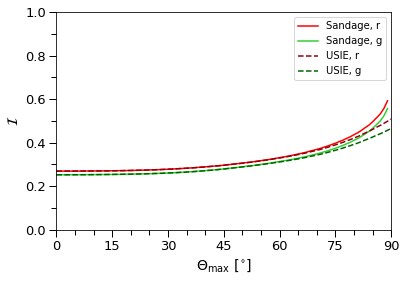

In [52]:
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=label_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)  
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.plot(angle_array[:90], sandager256i, 'r', label = "Sandage, r")
plt.plot(angle_array[:90], sandageg256i, 'limegreen', label = "Sandage, g")
plt.plot(angle_array[:91], mezgerr256i, '#8C000F', linestyle = 'dashed', label = "USIE, r")
plt.plot(angle_array[:91], mezgerg256i, 'darkgreen', linestyle = 'dashed', label = "USIE, g")
plt.margins(x=0, y=0)

ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticks([0,5,10,20,25,35,40,50,55,65,70,80,85], minor = True)
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
plt.xlabel("$\u0398_{\mathregular{max}}~[^{\circ}]$")
plt.ylabel("$\mathcal{I}$")
# ax.set_xticks([-180,-135,-90,-45,0,45,90,135,180])
# ax.set_xticks([-15,-30,-60,-75,-105,-120,-150,-165,15,30,60,75,105,120, 150,165], minor = True)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor = True)
plt.legend(loc = "best")
plt.savefig("./plots/inormusiesand_revised.pdf", dpi = 600, bbox_inches = 'tight')
plt.show()

In [36]:
def write_cloud():
    for i in range(0,6):
        f = open('cloudad_r_'+str(i)+'.txt', "w")
        for value in cloudad_r[i]:
            f.write(str(value)) 
            f.write("\n")
        f.close()

In [34]:
cloud0_gpol_fracs = np.loadtxt("sep23cloudfracgad.txt")
cloud0_gpol_angles = np.loadtxt("sep23cloudanglegad.txt")
cloud0_pol_fracs = np.loadtxt("sep23cloudfracrad.txt")
cloud0_angles = np.loadtxt("cloudEM_0.txt")
cloud0_pol_angles = np.loadtxt("sep23cloudanglerad.txt")
cloudEM_gpol_fracs = np.loadtxt("sep23cloudfracg.txt")
cloudEM_gpol_angles = np.loadtxt("sep23cloudangleg.txt")
cloudEM_pol_fracs = np.loadtxt("sep23cloudfracr.txt")
cloudEM_angles = np.loadtxt("cloudEM_0.txt")
cloudEM_pol_angles = np.loadtxt("sep23cloudangler.txt")

# 'mixedgillumang.txt'
# cloudEM_gpol_fracs = np.loadtxt('mixedgillumfrac.txt')
# cloudEM_gpol_angles = np.loadtxt('mixedgillumang.txt')
# cloudEM_pol_fracs = np.loadtxt('mixedrillumfrac.txt')
# # cloudEM_angles = np.loadtxt('mixedrillumang.txt')
# cloudEM_pol_angles = np.loadtxt('mixedrillumang.txt')

In [53]:
cloud0_reorder_angles = []
cloud0_reorder_pol_fracs = []
cloud0_reorder_pol_angles = []
cloud0_reorder_gpol_fracs = []
cloud0_reorder_gpol_angles = []
for i in cloud0_angles[180:360]:
    cloud0_reorder_angles.append(i)
    cloud0_reorder_pol_fracs.append(cloud0_pol_fracs[int(i)])
    cloud0_reorder_pol_angles.append(cloud0_pol_angles[int(i)])
    cloud0_reorder_gpol_fracs.append(cloud0_gpol_fracs[int(i)])
    cloud0_reorder_gpol_angles.append(cloud0_gpol_angles[int(i)])
for i in cloud0_angles[0:181]:
    cloud0_reorder_angles.append(i)
    cloud0_reorder_pol_fracs.append(cloud0_pol_fracs[int(i)])
    cloud0_reorder_pol_angles.append(cloud0_pol_angles[int(i)])
    cloud0_reorder_gpol_fracs.append(cloud0_gpol_fracs[int(i)])
    cloud0_reorder_gpol_angles.append(cloud0_gpol_angles[int(i)])

In [54]:
cloudEM_reorder_angles = []
cloudEM_reorder_pol_fracs = []
cloudEM_reorder_pol_angles = []
cloudEM_reorder_gpol_fracs = []
cloudEM_reorder_gpol_angles = []
for i in cloudEM_angles[180:360]:
    cloudEM_reorder_angles.append(i)
    cloudEM_reorder_pol_fracs.append(cloudEM_pol_fracs[int(i)])
    cloudEM_reorder_pol_angles.append(cloudEM_pol_angles[int(i)])
    cloudEM_reorder_gpol_fracs.append(cloudEM_gpol_fracs[int(i)])
    cloudEM_reorder_gpol_angles.append(cloudEM_gpol_angles[int(i)])
for i in cloudEM_angles[0:181]:
    cloudEM_reorder_angles.append(i)
    cloudEM_reorder_pol_fracs.append(cloudEM_pol_fracs[int(i)])
    cloudEM_reorder_pol_angles.append(cloudEM_pol_angles[int(i)])
    cloudEM_reorder_gpol_fracs.append(cloudEM_gpol_fracs[int(i)])
    cloudEM_reorder_gpol_angles.append(cloudEM_gpol_angles[int(i)])

In [55]:
ad_g_i = np.loadtxt("cloudad_g_5.txt")
ad_r_i = np.loadtxt("cloudad_r_5.txt")
dustem_r_i = np.loadtxt("clouddustem_r_5.txt")
dustem_g_i = np.loadtxt("clouddustem_g_5.txt")
cloudangles = np.loadtxt("cloudEM_0.txt")
cloudEM_angles = np.loadtxt("cloudEM_0.txt")

In [56]:
ad_r_i_reordered = []
ad_g_i_reordered = []
dustem_r_i_reordered = []
dustem_g_i_reordered = []
reorder_angles = []
for i in cloudEM_angles[180:360]:
    reorder_angles.append(i)
    ad_r_i_reordered.append(ad_r_i[int(i)]/8899614361430.283)
    ad_g_i_reordered.append(ad_g_i[int(i)]/4722065850848.031)
    dustem_r_i_reordered.append(dustem_r_i[int(i)]/8899614361430.283)
    dustem_g_i_reordered.append(dustem_g_i[int(i)]/4722065850848.031)
for i in cloudEM_angles[0:181]:
    reorder_angles.append(i)
    ad_r_i_reordered.append(ad_r_i[int(i)]/8899614361430.283)
    ad_g_i_reordered.append(ad_g_i[int(i)]/4722065850848.031)
    dustem_r_i_reordered.append(dustem_r_i[int(i)]/8899614361430.283)
    dustem_g_i_reordered.append(dustem_g_i[int(i)]/4722065850848.031)
# ad_r_i_reordered.reverse()
# ad_g_i_reordered.reverse()
# dustem_r_i_reordered.reverse()
# dustem_g_i_reordered.reverse()
# reorder_angles.reverse()

In [59]:
galangles = []
for i in cloud0_reorder_angles[0:181]:
    diff = int(cloud0_reorder_angles[int(i)])-180
#     print(diff)
    galangles.append(diff)
for i in range(1,181):
    galangles.append(i)
reorder_angles = galangles

In [6]:
xt = [-180,-135,-90,-45,0,45,90,135,180]
xtm = [-15,-30,-60,-75,-105,-120,-150,-165,15,30,60,75,105,120, 150,165]

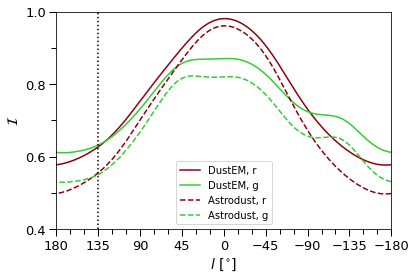

In [61]:
### FOR I
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=label_SIZE)   
plt.rc('xtick', labelsize=MEDIUM_SIZE)  
plt.rc('ytick', labelsize=MEDIUM_SIZE)  
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.plot(galangles, dustem_r_i_reordered, '#8C000F', label = "DustEM, r")
plt.plot(galangles,dustem_g_i_reordered, 'limegreen', label = "DustEM, g")
plt.plot(galangles, ad_r_i_reordered, '#8C000F', linestyle='dashed', label = "Astrodust, r")
plt.plot(galangles, ad_g_i_reordered, 'limegreen', linestyle='dashed', label = "Astrodust, g")

plt.ylabel("$\mathcal{I}$")
plt.xlabel("$\it{l}~[^{\circ}]$")
plt.margins(x=0,y=0)
ax.invert_xaxis()
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
ax.set_xticks(xt)
ax.set_xticks(xtm, minor = True)
# ax.set_yticks([0*10**12,1*10**12,3*10**12,5*10**12,7*10**12], minor = True)
ax.set_yticks([0.4,0.6,0.8,1.0]) 
ax.set_yticks([0.5,0.7,0.9], minor = True)
plt.axvline(x=135, c = 'black', linestyle = 'dotted')
plt.legend(loc = "lower center")
plt.savefig("./plots/cloudmover_i_revised.pdf", dpi = 600, bbox_inches='tight')
plt.show()

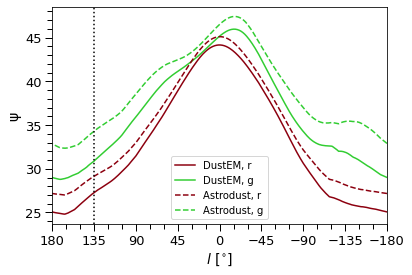

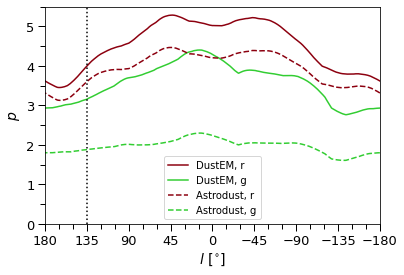

In [88]:
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=label_SIZE) 
plt.rc('xtick', labelsize=MEDIUM_SIZE)  
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.plot(galangles, cloudEM_reorder_pol_angles, '#8C000F', label = "DustEM, r")
plt.plot(galangles, cloudEM_reorder_gpol_angles, 'limegreen', label = "DustEM, g")
plt.plot(galangles, cloud0_reorder_pol_angles, '#8C000F', linestyle='dashed', label = "Astrodust, r")
plt.plot(galangles, cloud0_reorder_gpol_angles, 'limegreen', linestyle='dashed', label = "Astrodust, g")
plt.ylabel("\u03C8")
plt.xlabel("$\it{l}~[^{\circ}]$")
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
ax.invert_xaxis()
ax.set_xticks(xt)
ax.set_xticks(xtm, minor = True)
ax.set_yticks([24,26,27,28,29,31,32,33,34,36,37,38,39,41,42,43,44,46,47, 48], minor = True)
plt.margins(x=0)
plt.axvline(x=135, c = 'black', linestyle = 'dotted')
plt.legend(loc = "lower center")
plt.savefig("./plots/cloudmover_polang_revised.pdf", dpi = 600, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.plot(galangles, cloudEM_reorder_pol_fracs, '#8C000F', label = "DustEM, r")
plt.plot(galangles, cloudEM_reorder_gpol_fracs, 'limegreen', label = "DustEM, g")
plt.plot(galangles, cloud0_reorder_pol_fracs, '#8C000F', linestyle='dashed', label = "Astrodust, r")
plt.plot(galangles, cloud0_reorder_gpol_fracs, 'limegreen', linestyle='dashed', label = "Astrodust, g")
plt.ylabel("$\it{p}$")
plt.xlabel("$\it{l}~[^{\circ}]$")
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
ax.set_xticks(xt)
ax.set_xticks(xtm, minor = True)
ax.invert_xaxis()
ax.set_yticks([0,0.5,1.5,2.5,3.5,4.5, 5.5], minor = True)
plt.margins(x=0)
plt.axvline(x=135, c = 'black', linestyle = 'dotted')
plt.legend(loc = "lower center")
plt.savefig("./plots/cloudmover_polfrac_revised.pdf", dpi = 600, bbox_inches='tight')
plt.show()

In [63]:
latmoverangg = [34.29205574, 34.99483321, 35.69301255, 36.38406665, 37.06552958,
        37.73502724, 38.39029304, 39.02921208, 39.64985329, 40.25045098,
        40.82944649, 41.38549861, 41.917479  , 42.42448092, 42.90583201,
        43.3610555, 43.78987334, 44.19220334, 44.56815202, 44.91797103,
        45.24205104, 45.54093619, 45.81529836, 46.06590793, 46.29360946,
        46.49932178, 46.68403868, 46.8487884 , 46.99464612, 47.12270065,
        47.23403613, 47.32975077, 47.41094794, 47.47870263, 47.53405867,
        47.57802943, 47.61158194, 47.63563549, 47.65108738, 47.6587598,
        47.65940721, 47.65376222, 47.64247798, 47.62613131, 47.6052872,
        47.58041788, 47.55195677, 47.52027603, 47.48572474, 47.44859681,
        47.40909583, 47.36744019, 47.32381789, 47.27838262, 47.23125573,
        47.18252178, 47.13228489, 47.08064125, 47.0276593, 46.97334332,
        46.9177571, 46.86097837, 46.80305167, 46.74403294, 46.68400544,
        46.6230465, 46.56122493, 46.4986127, 46.4352719, 46.37129236,
        46.30677241, 46.24179485, 46.17642685, 46.11074009, 46.04484329,
        45.978815, 45.91271663, 45.84661397, 45.78057206, 45.71462244,
        45.64882604, 45.58319295, 45.51772173, 45.45243541, 45.38734077,
        45.32248114, 45.25778561, 45.19328503, 45.12903287, 45.06466788,
        44.99178673]
latmoverfracg = [3.85700031e+00, 3.94219657e+00, 4.03148772e+00, 4.12496501e+00,
        4.22268274e+00, 4.32465328e+00, 4.43084561e+00, 4.54118375e+00,
        4.65554449e+00, 4.77375653e+00, 4.89560217e+00, 5.02081696e+00,
        5.14909179e+00, 5.28007471e+00, 5.41337511e+00, 5.54856552e+00,
        5.68518590e+00, 5.82274954e+00, 5.96074801e+00, 6.09865428e+00,
        6.23592964e+00, 6.37203045e+00, 6.50641107e+00, 6.63853002e+00,
        6.76785249e+00, 6.89385763e+00, 7.01604126e+00, 7.13391770e+00,
        7.24702463e+00, 7.35492330e+00, 7.45720001e+00, 7.55347056e+00,
        7.64337894e+00, 7.72659502e+00, 7.80281552e+00, 7.87176445e+00,
        7.93319279e+00, 7.98687617e+00, 8.03261558e+00, 8.07023204e+00,
        8.09957054e+00, 8.12049802e+00, 8.13289813e+00, 8.13667570e+00,
        8.13175563e+00, 8.11807443e+00, 8.09558792e+00, 8.06426770e+00,
        8.02410286e+00, 7.97509459e+00, 7.91725818e+00, 7.85062604e+00,
        7.77524555e+00, 7.69117631e+00, 7.59849046e+00, 7.49727118e+00,
        7.38762018e+00, 7.26964910e+00, 7.14348020e+00, 7.00924382e+00,
        6.86709104e+00, 6.71718218e+00, 6.55968678e+00, 6.39478366e+00,
        6.22266332e+00, 6.04352512e+00, 5.85757660e+00, 5.66503189e+00,
        5.46611444e+00, 5.26105514e+00, 5.05009139e+00, 4.83346687e+00,
        4.61143031e+00, 4.38423759e+00, 4.15214969e+00, 3.91543120e+00,
        3.67435158e+00, 3.42918519e+00, 3.18020851e+00, 2.92770336e+00,
        2.67195277e+00, 2.41324452e+00, 2.15186643e+00, 1.88810723e+00,
        1.62225875e+00, 1.35461965e+00, 1.08548780e+00, 8.15163472e-01,
        5.43941087e-01, 2.72119796e-01, 4.68377359e-12]
latmoverangr = [31.89272345, 32.47666796, 33.05919094, 33.63873189, 34.21373208,
        34.78266104, 35.34404269, 35.89645132, 36.43853251, 36.96903132,
        37.48678375, 37.99073753, 38.47994811, 38.9535924 , 39.41097759,
        39.85150357, 40.27470413, 40.68023105, 41.06785836, 41.43744649,
        41.78896209, 42.12246753, 42.43810497, 42.73609786, 43.01675675,
        43.28042649, 43.5275116 , 43.75847326, 43.9738    , 44.17402293,
        44.35970874, 44.53141051, 44.68971733, 44.83524232, 44.96858448,
        45.09033674, 45.20108908, 45.30144951, 45.39202469, 45.47336252,
        45.54602915, 45.61057613, 45.66748937, 45.71728134, 45.76043168,
        45.79740801, 45.82867079, 45.85464162, 45.87569498, 45.89219708,
        45.90451231, 45.91297035, 45.91784406, 45.91945125, 45.91804881,
        45.91387544, 45.90714902, 45.89805989, 45.886819  , 45.87356747,
        45.85848534, 45.84175551, 45.82348394, 45.80380894, 45.7828375 ,
        45.76067229, 45.7374068 , 45.71311088, 45.68788176, 45.66179723,
        45.63490717, 45.60726861, 45.57894183, 45.54998439, 45.52042343,
        45.49032371, 45.45974991, 45.42869176, 45.39720648, 45.36537089,
        45.33320769, 45.30074863, 45.2680308 , 45.2351028 , 45.20198134,
        45.16866446, 45.13521184, 45.10157784, 45.06784326, 45.03400377,
        44.9730704 ]
latmoverfracr = [5.00126563e+00, 5.09394488e+00, 5.18997141e+00, 5.28943712e+00,
        5.39240569e+00, 5.49891107e+00, 5.60895543e+00, 5.72250578e+00,
        5.83949426e+00, 5.95981613e+00, 6.08332855e+00, 6.20985069e+00,
        6.33916358e+00, 6.47101071e+00, 6.60509775e+00, 6.74109503e+00,
        6.87863996e+00, 7.01733808e+00, 7.15676588e+00, 7.29647258e+00,
        7.43598459e+00, 7.57480852e+00, 7.71243437e+00, 7.84833997e+00,
        7.98199375e+00, 8.11285779e+00, 8.24039401e+00, 8.36406754e+00,
        8.48334839e+00, 8.59771726e+00, 8.70666703e+00, 8.80970582e+00,
        8.90636426e+00, 8.99619365e+00, 9.07876757e+00, 9.15368536e+00,
        9.22057444e+00, 9.27909237e+00, 9.32892500e+00, 9.36978624e+00,
        9.40142285e+00, 9.42360989e+00, 9.43615021e+00, 9.43888074e+00,
        9.43166421e+00, 9.41439313e+00, 9.38698695e+00, 9.34938908e+00,
        9.30156520e+00, 9.24350777e+00, 9.17523114e+00, 9.09676941e+00,
        9.00817737e+00, 8.90953193e+00, 8.80092252e+00, 8.68245604e+00,
        8.55425733e+00, 8.41646379e+00, 8.26922960e+00, 8.11271937e+00,
        7.94711683e+00, 7.77261503e+00, 7.58941396e+00, 7.39772670e+00,
        7.19777352e+00, 6.98978683e+00, 6.77400605e+00, 6.55067904e+00,
        6.32006428e+00, 6.08242594e+00, 5.83803635e+00, 5.58717508e+00,
        5.33012779e+00, 5.06718566e+00, 4.79864500e+00, 4.52480980e+00,
        4.24598805e+00, 3.96249021e+00, 3.67463482e+00, 3.38274159e+00,
        3.08713377e+00, 2.78814002e+00, 2.48608952e+00, 2.18131531e+00,
        1.87415214e+00, 1.56493652e+00, 1.25400615e+00, 9.41703189e-01,
        6.28370292e-01, 3.14354604e-01, 2.02401275e-12]
angles = [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
        78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.]
bs = [0,22.76,40,64.5,76.59,83.20,87.27,88.63,89.32,89.54]

In [64]:
#r band frankie
rfrankieang = [ 1.02315627,  15.53421145,  27.26240772,   5.72750231,
               -34.6416047 , -40.37925402, -42.12142794,  44.51359668,46.05263303,  46.08606237]
rfrankiefrac = [2.83089081, 3.17216523, 3.99555354, 1.42977388, 4.23815353,7.21164595, 4.87365787, 0.7407314 , 3.9709682 , 3.45467906]
lats = [ 0., 22.76047627, 40., 64.51279521, 76.59365039,83.20380884, 87.27076805, 88.6346095 , 89.31720781, 89.54479324]
#g band frankie
gfrankieang =[ -6.0501753 ,  29.46362963,  30.87481711,  27.2737923 ,
        -29.12179662, -38.78048816, -38.49169553,  45.80947463,
         46.14783282,  46.12298782]
gfrankiefrac =[1.82496731, 2.39391858, 3.15672682, 1.26271765, 2.46516734,4.17216496, 1.48929784, 4.13854196, 6.77433866, 5.28827821]
rfrankieang1 = [27.26240772,   5.72750231,180-34.6416047]
rfrankieang2= [27.26240772,  21.66351871, 180-32.33436662]
rfrankiefrac1 = [3.99555354, 1.42977388, 4.23815353]
rfrankiefrac2 = [3.99555354, 1.42375525, 0.82755039]
gfrankieang1 = [30.87481711,  27.2737923 ,180-29.12179662]
gfrankieang2 = [30.87481711,  23.33869252, 180-10.30678741]
gfrankiefrac1 = [3.15672682, 1.26271765, 2.46516734]
gfrankiefrac2 = [3.15672682, 1.41392267, 0.75550426]
lats1 = [40., 64.51279521, 76.59365039]

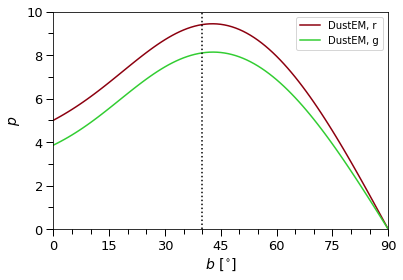

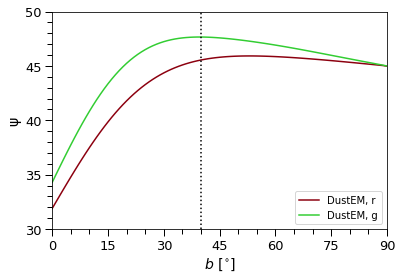

In [77]:
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=label_SIZE) 
plt.rc('xtick', labelsize=MEDIUM_SIZE)  
plt.rc('ytick', labelsize=MEDIUM_SIZE)  
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.plot(angles, latmoverfracr, '#8C000F', label = "DustEM, r")
plt.plot(angles, latmoverfracg, 'limegreen', label = "DustEM, g")
plt.ylabel("$\it{p}$")
plt.xlabel("$\it{b}~[^{\circ}]$")
plt.margins(x=0, y=0)
ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticks([5,10,20,25,35,40,50,55,65,70,80,85], minor = True)
ax.set_yticks([0,2,4,6,8,10])
ax.set_yticks([1,3,5,7,9], minor = True)
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='best')
plt.axvline(x=40, c = 'black', linestyle = 'dotted')
plt.savefig("./plots/latmoverfrac_revised.pdf", dpi = 600, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots()
plt.plot(angles, latmoverangr, '#8C000F', label = 'DustEM, r')
plt.plot(angles, latmoverangg, 'limegreen', label = 'DustEM, g')
plt.ylabel("\u03C8")
plt.xlabel("$\it{b}~[^{\circ}]$")
plt.margins(x=0, y=0)
ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticks([5,10,20,25,35,40,50,55,65,70,80,85], minor = True)
ax.set_yticks([30,35,40,45,50])
ax.set_yticks([31,32,33,34,36,37,38,39,41,42,43,44,46,47,48,49], minor = True)
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='lower right')
plt.axvline(x=40, c = 'black', linestyle = 'dotted')
plt.savefig("./plots/latmoverang_revised.pdf", dpi = 600, bbox_inches="tight")
plt.show()

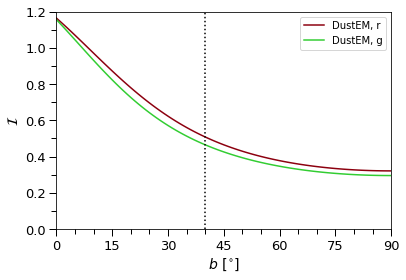

In [87]:
fig, ax = plt.subplots()

SMALLER_SIZE = 10   
SMALL_SIZE = 12
MEDIUM_SIZE = 13
label_SIZE = 14
plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=label_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALLER_SIZE)
plt.plot(angles, I_latr, '#8C000F', label = "DustEM, r")
plt.plot(angles, I_latg, 'limegreen', label = "DustEM, g")

plt.ylabel("$\mathcal{I}$")
plt.xlabel("$\it{b}~[^{\circ}]$")
plt.margins(x=0, y=0)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xticks([5,10,20,25,35,40,50,55,65,70,80,85], minor = True)
ax.set_yticks([0.1,0.3,0.5,0.7,0.9,1.1], minor = True)
ax.tick_params('both', length=7, width=1, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
plt.legend(loc='best')
plt.axvline(x=40, c = 'black', linestyle = 'dotted')
plt.savefig("./plots/latmoverI_revised.pdf", dpi = 600, bbox_inches="tight")
plt.show()

In [69]:
latgi = np.loadtxt("23latg256i.txt")
latgillum = np.loadtxt("23latg256illum.txt")
latri = np.loadtxt("23latr256i.txt")
latrillum = np.loadtxt("23latr256illum.txt")
I_latg = np.full(91, 0, dtype = float)
for ele in range(0,91):
    I_latg[ele] = latgi[ele]/latgillum[ele]
print(I_latg) 
I_latr = np.full(91, 0, dtype = float)
for ele in range(0,91):
    I_latr[ele] = latri[ele]/latrillum[ele]

[1.15527117 1.13351921 1.11142445 1.08905554 1.06648141 1.04377068
 1.02099088 0.99820783 0.97548508 0.95288337 0.93046012 0.90826904
 0.88635979 0.86477785 0.84356421 0.82275526 0.8023829  0.78247446
 0.76305282 0.74413656 0.72574019 0.70787438 0.69054622 0.67375941
 0.6575147  0.64181006 0.62664113 0.61200142 0.59788265 0.58427495
 0.57116724 0.55854736 0.54640236 0.53471872 0.52348253 0.5126796
 0.50229553 0.49231603 0.48272694 0.47351429 0.46466431 0.45616361
 0.4479992  0.44015841 0.43262903 0.42539937 0.41845821 0.41179471
 0.40539854 0.39925983 0.39336913 0.38771749 0.38229636 0.37709764
 0.37211365 0.36733711 0.36276114 0.35837916 0.35418497 0.35017273
 0.34633687 0.34267208 0.3391734  0.3358361  0.33265575 0.32962812
 0.32674921 0.32401525 0.32142266 0.31896808 0.31664832 0.31446036
 0.31240137 0.31046866 0.30865972 0.30697221 0.30540388 0.30395269
 0.3026167  0.30139415 0.3002834  0.29928296 0.29839147 0.29760772
 0.29693063 0.2963593  0.29589292 0.29553084 0.29527256 0.29511

In [18]:
def sandage_89(model, z, ifilt, nside_whole_sky, nside_limit_89):
    sandagewholesky = sandage_whole_sky(1, 0.2, 1, nside_whole_sky, 89, plot = False, limit_89 = True)
    pol_angles = sandagewholesky[0]
    pol_fracs = sandagewholesky[1]
    pol_angle_0 = sandagewholesky[2]
    pol_frac_0 = sandagewholesky[3] 
    pol_angle_90 = sandagewholesky[4] 
    pol_frac_90 = sandagewholesky[5]
    print('pol angles limits')
    print(np.shape(pol_angle_90))
    print(np.shape(pol_angle_0))
    print('pol fracs limits')
    print(np.shape(pol_frac_90))
    print(np.shape(pol_frac_0))
    print('pol fracs, pol angs')
    print(np.shape(pol_fracs))
    print(np.shape(pol_angles))
    whole_sky_89 =  whole_sky(model, z, ifilt, nside_limit_89, 89.9, sandage = True,\
                    info = False, interp_type = 'linear', l2 = 135., b2 = 40., anisotropic = True, \
                  rayleigh = False, start = 0)
    if whole_sky_89[0] < 0:
        pol_angle_89 = whole_sky_89[0] + 180.
    else:
        pol_angle_89 = whole_sky_89[0]
    pol_frac_89 = whole_sky_89[2]
    print(np.shape(np.array([pol_angle_89])))
    print(np.shape(np.array([pol_frac_89])))    
    all_pol_angles = np.append(pol_angles, np.array([pol_angle_89]))
    all_pol_fracs = np.append(pol_fracs, np.array([pol_frac_89]))
    angle_array = np.loadtxt("angle_array.txt")
    thetas = angle_array[1:91]
    thetas[89] = 89.9
    print(np.shape(thetas))
    print(np.shape(all_pol_fracs))
    print(np.shape(all_pol_angles))
    
    plt.plot(thetas, all_pol_angles, 'red')
    plt.plot(90, pol_angle_90, 'x')
    plt.plot(0, pol_angle_0, 'yx')
    plt.xlabel('Theta Max')
    plt.ylabel('Polarization Angle')
    plt.show()
    plt.plot(thetas, all_pol_fracs, 'orange')
    plt.plot(90, pol_frac_90, 'x')
    plt.plot(0, pol_frac_0, 'rx')
    plt.xlabel('Theta Max')
    plt.ylabel('Polarization Fraction')
    plt.show()
     
    return sum(all_pol_angles), sum(all_pol_fracs),


In [19]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors

In [37]:
def mollview(ifilt, z, norm_type = 'linear', col_map = 'jet'):
    corrected_skyfilt = np.where(skyfilt(ifilt, z) == 0, 10e-5, skyfilt(ifilt, z))
    col_map = colors.LinearSegmentedColormap.from_list("", ["white","red"])
    sky = hp.mollview(corrected_skyfilt, norm = norm_type,  min = 1e6, cbar = None, cmap = col_map, unit = 'J/sr', title = None)
    hp.graticule()
    
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]

In [27]:
def projview(ifilt, z):
    corrected_skyfilt = np.where(skyfilt(ifilt, z) == 0, 10e-5, skyfilt(ifilt, z))
    hp.projview(corrected_skyfilt, graticule=True,
    graticule_labels=True,
    unit="cbar label",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="vertical")

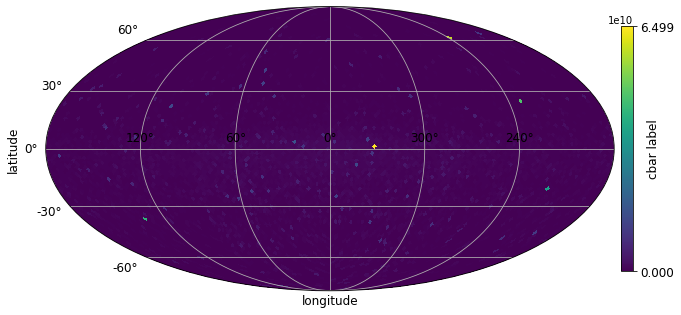

In [28]:
projview(1,0.2)

In [70]:
def map_smoother(ifilt, z, nside, max_value, norm_type = 'linear', col_map = 'jet'):
    total_pix = hp.nside2npix(nside)
    smoothed_skyfilt = skyfilt(ifilt, z)
    for pixel in range(0,total_pix):
        if smoothed_skyfilt[pixel] > max_value:
            oldpix = hp.pix2ang(nside, pixel, lonlat = True)

            newpix = hp.ang2pix(nside, (np.pi/180.)*oldpix[0], (np.pi/180.)*(oldpix[1] + 2))
            smoothed_skyfilt[pixel] = smoothed_skyfilt[newpix]
    hp.mollview(smoothed_skyfilt, norm = norm_type, cmap = col_map, unit = 'MeV', cbar = None)
    fig = plt.gcf() # get figure
    ax = plt.gca() # get axis
    image = ax.get_images()[0] #gets images which are attached to the axes
    fig.colorbar(image, ax=ax)
    hp.graticule()
    return smoothed_skyfilt

In [ ]:
hp.mollview(whole_sky(1, 0.2, 1, 32, 0, mollview =True)[1], norm = 'hist', cmap = 'jet', \
            title='U polarization')
hp.graticule()

In [77]:
 def mollview_plotter(model, ifilt):
    corrected_whole_sky = np.where(whole_sky(model, 0.2, ifilt, 32, 0, 135., 40.,90,mollview =True, info = False) == 0, 10e-5, whole_sky(model, 0.2, ifilt, 32, 0, 135., 40.,mollview =True, info = False))
    for i in range(0,5): 
        if i == 0:
            pol = 'Q sky'
        if i == 1:
            pol = 'U sky'
        if i == 2:
            pol = 'I sky'
#         if i == 3:
#             pol = 'Polarization Angle'
#         if i == 4:
#             pol = 'Polarization Fraction'
        hp.mollview(whole_sky(model, 0.2, ifilt, 32, 0, 135., 40.,90,mollview =True, info = False)[i], norm = 'log', cmap = 'jet', \
                title=pol)
    hp.graticule()

In [ ]:
hp.mollview(whole_sky(1, 0.2, 1, 32, 0, mollview =True)[1], norm = 'hist', cmap = 'jet', \
            title='U polarization')
hp.graticule()

In [85]:
def plotting_phase_fxns(model_1, model_2, model_3, model_4):
    angle_array = np.loadtxt("angle_array.txt")
    phase_fxn_1 = np.loadtxt("weighted_phase_fxn_"+ str(model_1)+".txt")
    pol_phase_fxn_1 = np.loadtxt("weighted_Q_"+ str(model_1)+".txt")
    phase_fxn_2 = np.loadtxt("weighted_phase_fxn_"+ str(model_2)+".txt")
    pol_phase_fxn_2 = np.loadtxt("weighted_Q_"+ str(model_2)+".txt")
    phase_fxn_3 = np.loadtxt("weighted_phase_fxn_"+ str(model_3)+".txt")
    pol_phase_fxn_3 = np.loadtxt("weighted_Q_"+ str(model_3)+".txt")
    phase_fxn_4 = np.loadtxt("weighted_phase_fxn_"+ str(model_4)+".txt")
    pol_phase_fxn_4 = np.loadtxt("weighted_Q_"+ str(model_4)+".txt")
    ray_phase_fxn_1 = np.loadtxt("rayleigh_phase.txt")
    ray_pol_phase_fxn_1 = np.loadtxt("rayleigh_pol.txt")

    SMALLER_SIZE = 10   
    SMALL_SIZE = 12
    MEDIUM_SIZE = 13
    label_SIZE = 14

    fig, ax = plt.subplots()
    plt.rc('font', size=SMALL_SIZE)
    plt.rc('axes', titlesize=MEDIUM_SIZE)  
    plt.rc('axes', labelsize=label_SIZE)
    plt.rc('xtick', labelsize=MEDIUM_SIZE)  
    plt.rc('ytick', labelsize=MEDIUM_SIZE)  
    plt.rc('legend', fontsize=SMALLER_SIZE) 
    
#     plt.plot(angle_array, phase_fxn_1, '#8C000F', label = "WD3.1, r")
#     plt.plot(angle_array, phase_fxn_2, 'limegreen', label = "WD3.1, g")
#     plt.plot(angle_array, phase_fxn_3, '#8C000F', linestyle='dashed', label = "WD5.5, r")
#     plt.plot(angle_array, phase_fxn_4, 'limegreen', linestyle='dashed', label = "WD5.5, g")
    plt.plot(angle_array, phase_fxn_1, '#8C000F', label = "DustEM, r")
    plt.plot(angle_array, phase_fxn_2, 'limegreen', label = "DustEM, g")
    plt.plot(angle_array, phase_fxn_3, '#8C000F', linestyle='dashed', label = "Astrodust, r")
    plt.plot(angle_array, phase_fxn_4, 'limegreen', linestyle='dashed', label = "Astrodust, g")
    plt.plot(angle_array, ray_phase_fxn_1, 'mediumblue', linestyle = 'dashdot', label = "Rayleigh")
    ax.set_yscale('log')
    ax.set_ylim(10**-1,13**1)
    ax.set_yticks([10**-1, 10**0, 10**1])
    ax.set_xticks([0,30,60,90,120,150,180])
    ax.set_xticks([15,45,75,105,135,165], minor = True)
    plt.xlabel("\u03B8$~[^{\circ}]$")
    plt.margins(x=0)
    plt.ylabel("log($I_{\mathregular{ph}}$)")
    plt.plot(angle_array, np.ones(181), 'black', linestyle = 'dotted')
    plt.legend(loc = "upper right")
#     plt.title("Phase Functions")
    plt.savefig("./plots/logphase_fxns_revised.pdf", dpi=600, bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots()
    
#     plt.plot(angle_array, pol_phase_fxn_1, '#8C000F', label = "WD3.1, r")
#     plt.plot(angle_array, pol_phase_fxn_2, 'limegreen', label = "WD3.1, g")
#     plt.plot(angle_array, pol_phase_fxn_3, '#8C000F', linestyle='dashed', label = "WD5.5, r")
#     plt.plot(angle_array, pol_phase_fxn_4, 'limegreen', linestyle='dashed', label = "WD5.5, g")
    plt.plot(angle_array, pol_phase_fxn_1, '#8C000F', label = "DustEM, r")
    plt.plot(angle_array, pol_phase_fxn_2, 'limegreen', label = "DustEM, g")
    plt.plot(angle_array, pol_phase_fxn_3, '#8C000F', linestyle='dashed', label = "Astrodust, r")
    plt.plot(angle_array, pol_phase_fxn_4, 'limegreen', linestyle='dashed', label = "Astrodust, g")
    plt.plot(angle_array, ray_pol_phase_fxn_1/3, 'mediumblue', linestyle = "dashdot", label = "Rayleigh/3")
    ax.set_yticks([10**-1, 10**0, 10**1])
#     ax.set_yscale('symlog')
    ax.set_ylim(-0.3,0.08)
    ax.set_xticks([0,30,60,90,120,150,180])
    ax.set_xticks([15,45,75,105,135,165], minor = True)
    ax.set_yticks([0,-0.1,-0.2])
    ax.set_yticks([0.05,0,-0.05,-0.1,-0.15,-0.2, -0.25], minor=True)
#     ax.set_yticks([0,-0.2,-0.4,-0.6,-0.8])
#     ax.set_yticks([-0.1,-0.3,-0.5,-0.7,-0.9], minor = True)

    plt.xlabel("\u03B8$~[^{\circ}]$")
    plt.margins(x=0)
    plt.ylabel("${Q_{\mathregular{ph}}}$")

    plt.plot(angle_array, np.zeros(181), 'black', linestyle = 'dotted')
    plt.legend(loc = "lower right")
    plt.savefig("./plots/pol_phase_fxns_revised.pdf", dpi=600, bbox_inches='tight')
#     plt.show()

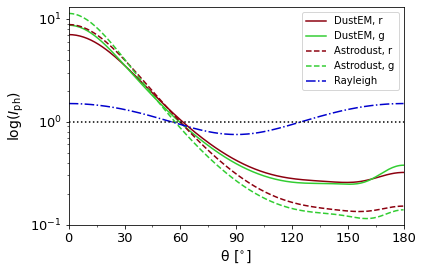

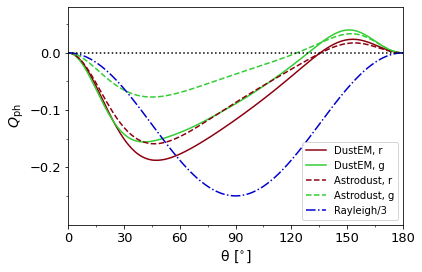

In [86]:
plotting_phase_fxns(0, 1, 6, 7)

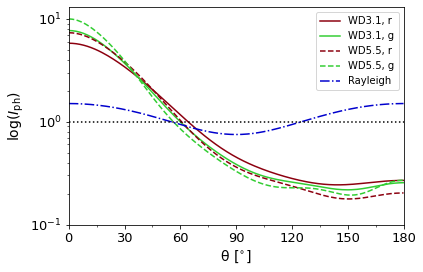

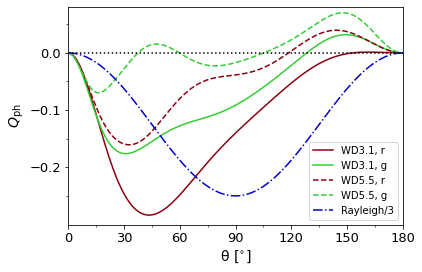

In [84]:
plotting_phase_fxns(2,3,4,5)

In [261]:
def all_phase_fxns():
    angle_array = np.loadtxt("angle_array.txt")
    for model in range(0,10):
        phase_fxn_1 = np.loadtxt("weighted_phase_fxn_"+ str(model)+".txt")
        plt.plot(angle_array, phase_fxn_1, label = str(model))
    plt.legend()
    plt.xlabel("Theta")
    plt.ylabel("Phase fxn I")
    plt.show()
    for model_2 in range(0,12):
        pol_phase_fxn_1 = np.loadtxt("weighted_Q_"+ str(model_2)+".txt")
        plt.plot(angle_array, pol_phase_fxn_1, label = str(model_2))
        print(pol_phase_fxn_1[19])
    
    plt.legend()
    plt.xlabel("Theta")
    plt.ylabel("Polarization phase fxn, Q")
    plt.show()    

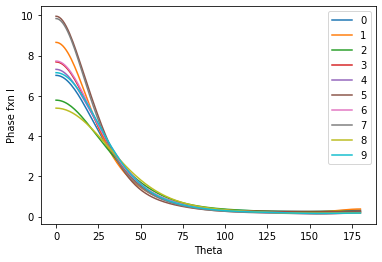

-0.08484464879900193
-0.08965471942478408
-0.15120139917244327
-0.14036427881621352
-0.12211283665109349
-0.06705540368743694
-0.04504999999999981
-0.017799999999999816
-0.08879999999999999
-0.05645000000000033
-0.04265000000000008
-0.020700000000000163


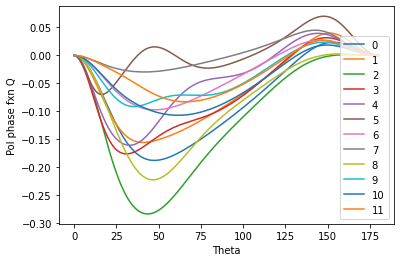

In [327]:
all_phase_fxns()

In [108]:
def log_plotting(modelno,pos_start, neg_endpoint, rayleigh = False):
    """Takes a function and plots the log of its positive y values normally, then 
    converts the negative y values to positive, takes the log and plots them
    in a different colour."""
    Q = np.loadtxt("weighted_Q_"+ str(modelno)+".txt")
    if rayleigh == True:
        Q = rayleigh_Q
    #positive values
    pos_values = np.asarray(np.argwhere(Q > 0))
    fxn_pos = Q[pos_values[pos_start:]]
#     plt.plot(angle_array[pos_values[pos_start:]],np.log(fxn_pos), pos_color)

    #negative values
    neg_values = np.asarray(np.argwhere(Q < 0))
    fxn_neg = (Q[neg_values[0:neg_endpoint]]) #excludes angle 180 since it is ~0
#     plt.plot(angle_array[neg_values[0:neg_endpoint]],np.log(abs(fxn_neg)), neg_color)
    return angle_array[pos_values[pos_start:]],np.log(fxn_pos), \
        angle_array[neg_values[0:neg_endpoint]],np.log(abs(fxn_neg))
            


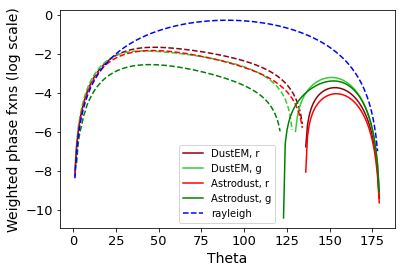

In [113]:
#I phase fxn
# plt.plot(sil_cols[0,:], np.log(weighted_I), 'bs')

model0 = log_plotting(0, 0, -1) 
model1 = log_plotting(1, 0, -1) 
model6 = log_plotting(6, 0, -1) 
model7 = log_plotting(7, 0, -1) 
modelrayleigh = log_plotting(0,0,-1, rayleigh = True)
plt.plot(model0[0], model0[1], '#8C000F', label = "DustEM, r")
plt.plot(model0[2], model0[3], '#8C000F', linestyle = 'dashed')
# plt.show()
plt.plot(model1[0], model1[1], 'limegreen', label = "DustEM, g")
plt.plot(model1[2], model1[3], 'limegreen', linestyle = 'dashed')

plt.plot(model6[0], model6[1], 'r', label = 'Astrodust, r')
plt.plot(model6[2], model6[3], 'r', linestyle = 'dashed')
# plt.show()
plt.plot(model7[0], model7[1], 'g', label = 'Astrodust, g')
plt.plot(model7[2], model7[3], 'g', linestyle = 'dashed')

# plt.plot(modelrayleigh[0], modelrayleigh[1], 'y', label = 'rayleigh')
plt.plot(modelrayleigh[2], modelrayleigh[3], 'b', linestyle = 'dashed', label = 'rayleigh')

#labels
plt.xlabel('Theta')
plt.ylabel('Weighted phase fxns (log scale)')
plt.legend(loc = 'best')